In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as matcol
import random
import math
import time
import datetime
import operator

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use('seaborn')
%matplotlib inline

In [65]:
cov_cases = pd.read_csv('./datasets/cases.csv')
cov_deaths = pd.read_csv('./datasets/deaths.csv')
cov_recovered = pd.read_csv('./datasets/recovered.csv')

In [66]:
cov_cases.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,47,48,50,50,50,53,59,70,75,82
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,360,420,461,502,511,581,639,639,701,773
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,117,130,138,150,150,160,178,178,200,212
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,50,83,93,99,117,129,149,149,197,238


In [11]:
cov_deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,NaN,Japan,36.0000,138.0000,0,0,0,0,0,0,...,6,6,6,6,10,10,15,16,19,22
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
cov_recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,2,2,...,31,31,31,31,31,33,34,34,35,35
1,NaN,Japan,36.0000,138.0000,0,0,0,0,1,1,...,43,46,76,76,76,101,118,118,118,118
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,...,78,78,78,78,78,78,96,96,97,105
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,...,22,22,23,24,24,24,26,26,26,35


In [17]:
col_names = cov_cases.keys()
col_names

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20'],
      dtype='object')

In [18]:
dates_cases = cov_cases.loc[:,col_names[4]:col_names[-1]]
dates_deaths = cov_deaths.loc[:,col_names[4]:col_names[-1]]
dates_recovered = cov_recovered.loc[:,col_names[4]:col_names[-1]]

In [75]:
dates = dates_cases.keys()
total_cases = []
total_deaths = []
mortality_rate = []
total_recovered = []

for date in dates:
    cases_sum = dates_cases[date].sum()
    deaths_sum = dates_deaths[date].sum()
    recovered_sum = dates_recovered[date].sum()
    
    total_cases.append(cases_sum)
    total_deaths.append(deaths_sum)
    total_recovered.append(recovered_sum)

In [35]:
cases_sum, deaths_sum, recovered_sum

(156102, 5819, 72624, 53)

In [47]:
days_since_22_jan = np.array([i for i in range(len(dates))]).reshape(-1, 1)
total_cases = np.array(total_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

In [70]:
future_days = 10
future_prediction = np.array([i for i in range(len(dates)+future_days)]).reshape(-1, 1)
adjusted_days = future_prediction[:-10]
future_prediction

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30],
       [31],
       [32],
       [33],
       [34],
       [35],
       [36],
       [37],
       [38],
       [39],
       [40],
       [41],
       [42],
       [43],
       [44],
       [45],
       [46],
       [47],
       [48],
       [49],
       [50],
       [51],
       [52],
       [53],
       [54],
       [55],
       [56],
       [57],
       [58],
       [59],
       [60],
       [61],
       [62]])

In [71]:
start = '22/1/2020'
start_date = datetime.datetime.strptime(start, '%d/%m/%Y')
future_prediction_dates = []
for i in range(len(future_prediction)):
    future_prediction_dates.append((start_date + datetime.timedelta(days=i)).strftime('%d/%m/%Y'))
future_prediction_dates

['22/01/2020',
 '23/01/2020',
 '24/01/2020',
 '25/01/2020',
 '26/01/2020',
 '27/01/2020',
 '28/01/2020',
 '29/01/2020',
 '30/01/2020',
 '31/01/2020',
 '01/02/2020',
 '02/02/2020',
 '03/02/2020',
 '04/02/2020',
 '05/02/2020',
 '06/02/2020',
 '07/02/2020',
 '08/02/2020',
 '09/02/2020',
 '10/02/2020',
 '11/02/2020',
 '12/02/2020',
 '13/02/2020',
 '14/02/2020',
 '15/02/2020',
 '16/02/2020',
 '17/02/2020',
 '18/02/2020',
 '19/02/2020',
 '20/02/2020',
 '21/02/2020',
 '22/02/2020',
 '23/02/2020',
 '24/02/2020',
 '25/02/2020',
 '26/02/2020',
 '27/02/2020',
 '28/02/2020',
 '29/02/2020',
 '01/03/2020',
 '02/03/2020',
 '03/03/2020',
 '04/03/2020',
 '05/03/2020',
 '06/03/2020',
 '07/03/2020',
 '08/03/2020',
 '09/03/2020',
 '10/03/2020',
 '11/03/2020',
 '12/03/2020',
 '13/03/2020',
 '14/03/2020',
 '15/03/2020',
 '16/03/2020',
 '17/03/2020',
 '18/03/2020',
 '19/03/2020',
 '20/03/2020',
 '21/03/2020',
 '22/03/2020',
 '23/03/2020',
 '24/03/2020']

In [69]:
latest_cases = cov_cases[dates[-1]]
latest_deaths = cov_deaths[dates[-1]]
latest_recovered = cov_recovered[dates[-1]]

In [78]:
countries = list(cov_cases['Country/Region'].unique())
countries

['Thailand',
 'Japan',
 'Singapore',
 'Nepal',
 'Malaysia',
 'Canada',
 'Australia',
 'Cambodia',
 'Sri Lanka',
 'Germany',
 'Finland',
 'United Arab Emirates',
 'Philippines',
 'India',
 'Italy',
 'Sweden',
 'Spain',
 'Belgium',
 'Egypt',
 'Lebanon',
 'Iraq',
 'Oman',
 'Afghanistan',
 'Bahrain',
 'Kuwait',
 'Algeria',
 'Croatia',
 'Switzerland',
 'Austria',
 'Israel',
 'Pakistan',
 'Brazil',
 'Georgia',
 'Greece',
 'North Macedonia',
 'Norway',
 'Romania',
 'Estonia',
 'Netherlands',
 'San Marino',
 'Belarus',
 'Iceland',
 'Lithuania',
 'Mexico',
 'New Zealand',
 'Nigeria',
 'Ireland',
 'Luxembourg',
 'Monaco',
 'Qatar',
 'Ecuador',
 'Azerbaijan',
 'Armenia',
 'Dominican Republic',
 'Indonesia',
 'Portugal',
 'Andorra',
 'Latvia',
 'Morocco',
 'Saudi Arabia',
 'Senegal',
 'Argentina',
 'Chile',
 'Jordan',
 'Ukraine',
 'Hungary',
 'Liechtenstein',
 'Poland',
 'Tunisia',
 'Bosnia and Herzegovina',
 'Slovenia',
 'South Africa',
 'Bhutan',
 'Cameroon',
 'Colombia',
 'Costa Rica',
 'Peru',

In [83]:
country_total_cases = []
no_cases = []
for country in countries:
    cases = latest_cases[cov_cases['Country/Region']==country].sum()
    if cases > 0:
        country_total_cases.append(cases)
    else:
        no_cases.append(country)

for country in no_cases:
    countries.remove(country)
    
countries = [k for k, v in sorted(zip(countries, country_total_cases), key=operator.itemgetter(1), reverse=1)]
for i in range(len(countries)):
    country_total_cases[i] = latest_cases[cov_cases['Country/Region']==countries[i]].sum()

In [84]:
print('No. of cases by Country/Region')
for i in range(len(countries)):
    print(f'{countries[i]} : {country_total_cases[i]}')

No. of cases by Country/Region
China : 80977
Italy : 21157
Iran : 12729
Korea, South : 8086
Spain : 6391
Germany : 4585
France : 4480
US : 2727
Switzerland : 1359
United Kingdom : 1143
Norway : 1090
Sweden : 961
Netherlands : 959
Denmark : 836
Japan : 773
Cruise Ship : 696
Belgium : 689
Austria : 655
Qatar : 337
Australia : 250
Malaysia : 238
Greece : 228
Finland : 225
Singapore : 212
Bahrain : 210
Canada : 198
Israel : 193
Czechia : 189
Slovenia : 181
Portugal : 169
Iceland : 156
Brazil : 151
Ireland : 129
Romania : 123
Estonia : 115
Philippines : 111
Iraq : 110
Egypt : 109
Kuwait : 104
Saudi Arabia : 103
Poland : 103
India : 102
Indonesia : 96
Lebanon : 93
United Arab Emirates : 85
Thailand : 82
San Marino : 80
Chile : 61
Russia : 59
Taiwan* : 53
Vietnam : 53
Luxembourg : 51
Serbia : 46
Slovakia : 44
Bulgaria : 41
Brunei : 40
Croatia : 38
South Africa : 38
Peru : 38
Albania : 38
Algeria : 37
Panama : 36
Argentina : 34
Pakistan : 31
Georgia : 30
Hungary : 30
Ecuador : 28
Belarus : 27


In [87]:
provinces = list(cov_cases['Province/State'].unique())
outliers = ['United Kingdom', 'Denmark', 'France']

for i in outliers:
    provinces.remove(i)

In [91]:
province_total_cases = []
no_cases = []

for province in provinces:
    cases = latest_cases[cov_cases['Province/State']==province].sum()
    if cases > 0:
        province_total_cases.append(cases)
    else:
        no_cases.append(province)
        
for province in no_cases:
    provinces.remove(province)

In [92]:
print('No. of cases by Province/State')
for i in range(len(provinces)):
    print(f'{provinces[i]} : {province_total_cases[i]}')

No. of cases by Province/State
British Columbia : 64
New South Wales : 112
Victoria : 49
Queensland : 46
South Australia : 19
Western Australia : 17
Tasmania : 5
Northern Territory : 1
Ontario : 79
Alberta : 29
Quebec : 17
Washington : 572
New York : 525
California : 340
Massachusetts : 138
Diamond Princess : 742
Grand Princess : 23
Georgia : 66
Colorado : 101
Florida : 76
New Jersey : 69
Oregon : 32
Texas : 57
Illinois : 64
Pennsylvania : 47
Iowa : 17
Maryland : 26
North Carolina : 24
South Carolina : 19
Tennessee : 32
Virginia : 41
Arizona : 12
Indiana : 16
Kentucky : 14
District of Columbia : 10
Nevada : 21
New Hampshire : 7
Minnesota : 21
Nebraska : 14
Ohio : 26
Rhode Island : 20
Wisconsin : 27
Connecticut : 22
Hawaii : 4
Oklahoma : 4
Utah : 10
Kansas : 8
Louisiana : 77
Missouri : 4
Vermont : 5
Alaska : 1
Arkansas : 12
Delaware : 6
Idaho : 2
Maine : 3
Michigan : 25
Mississippi : 6
Montana : 5
New Mexico : 10
North Dakota : 1
South Dakota : 9
Wyoming : 2
Hubei : 67790
Guangdong : 13

In [95]:
nan_values = []

for i in range(len(provinces)):
    if type(provinces[i]) == float:
        nan_values.append(i)

provinces = list(provinces)
province_total_cases = list(province_total_cases)

for i in nan_values:
    provinces.pop(i)
    province_total_cases.pop(i)

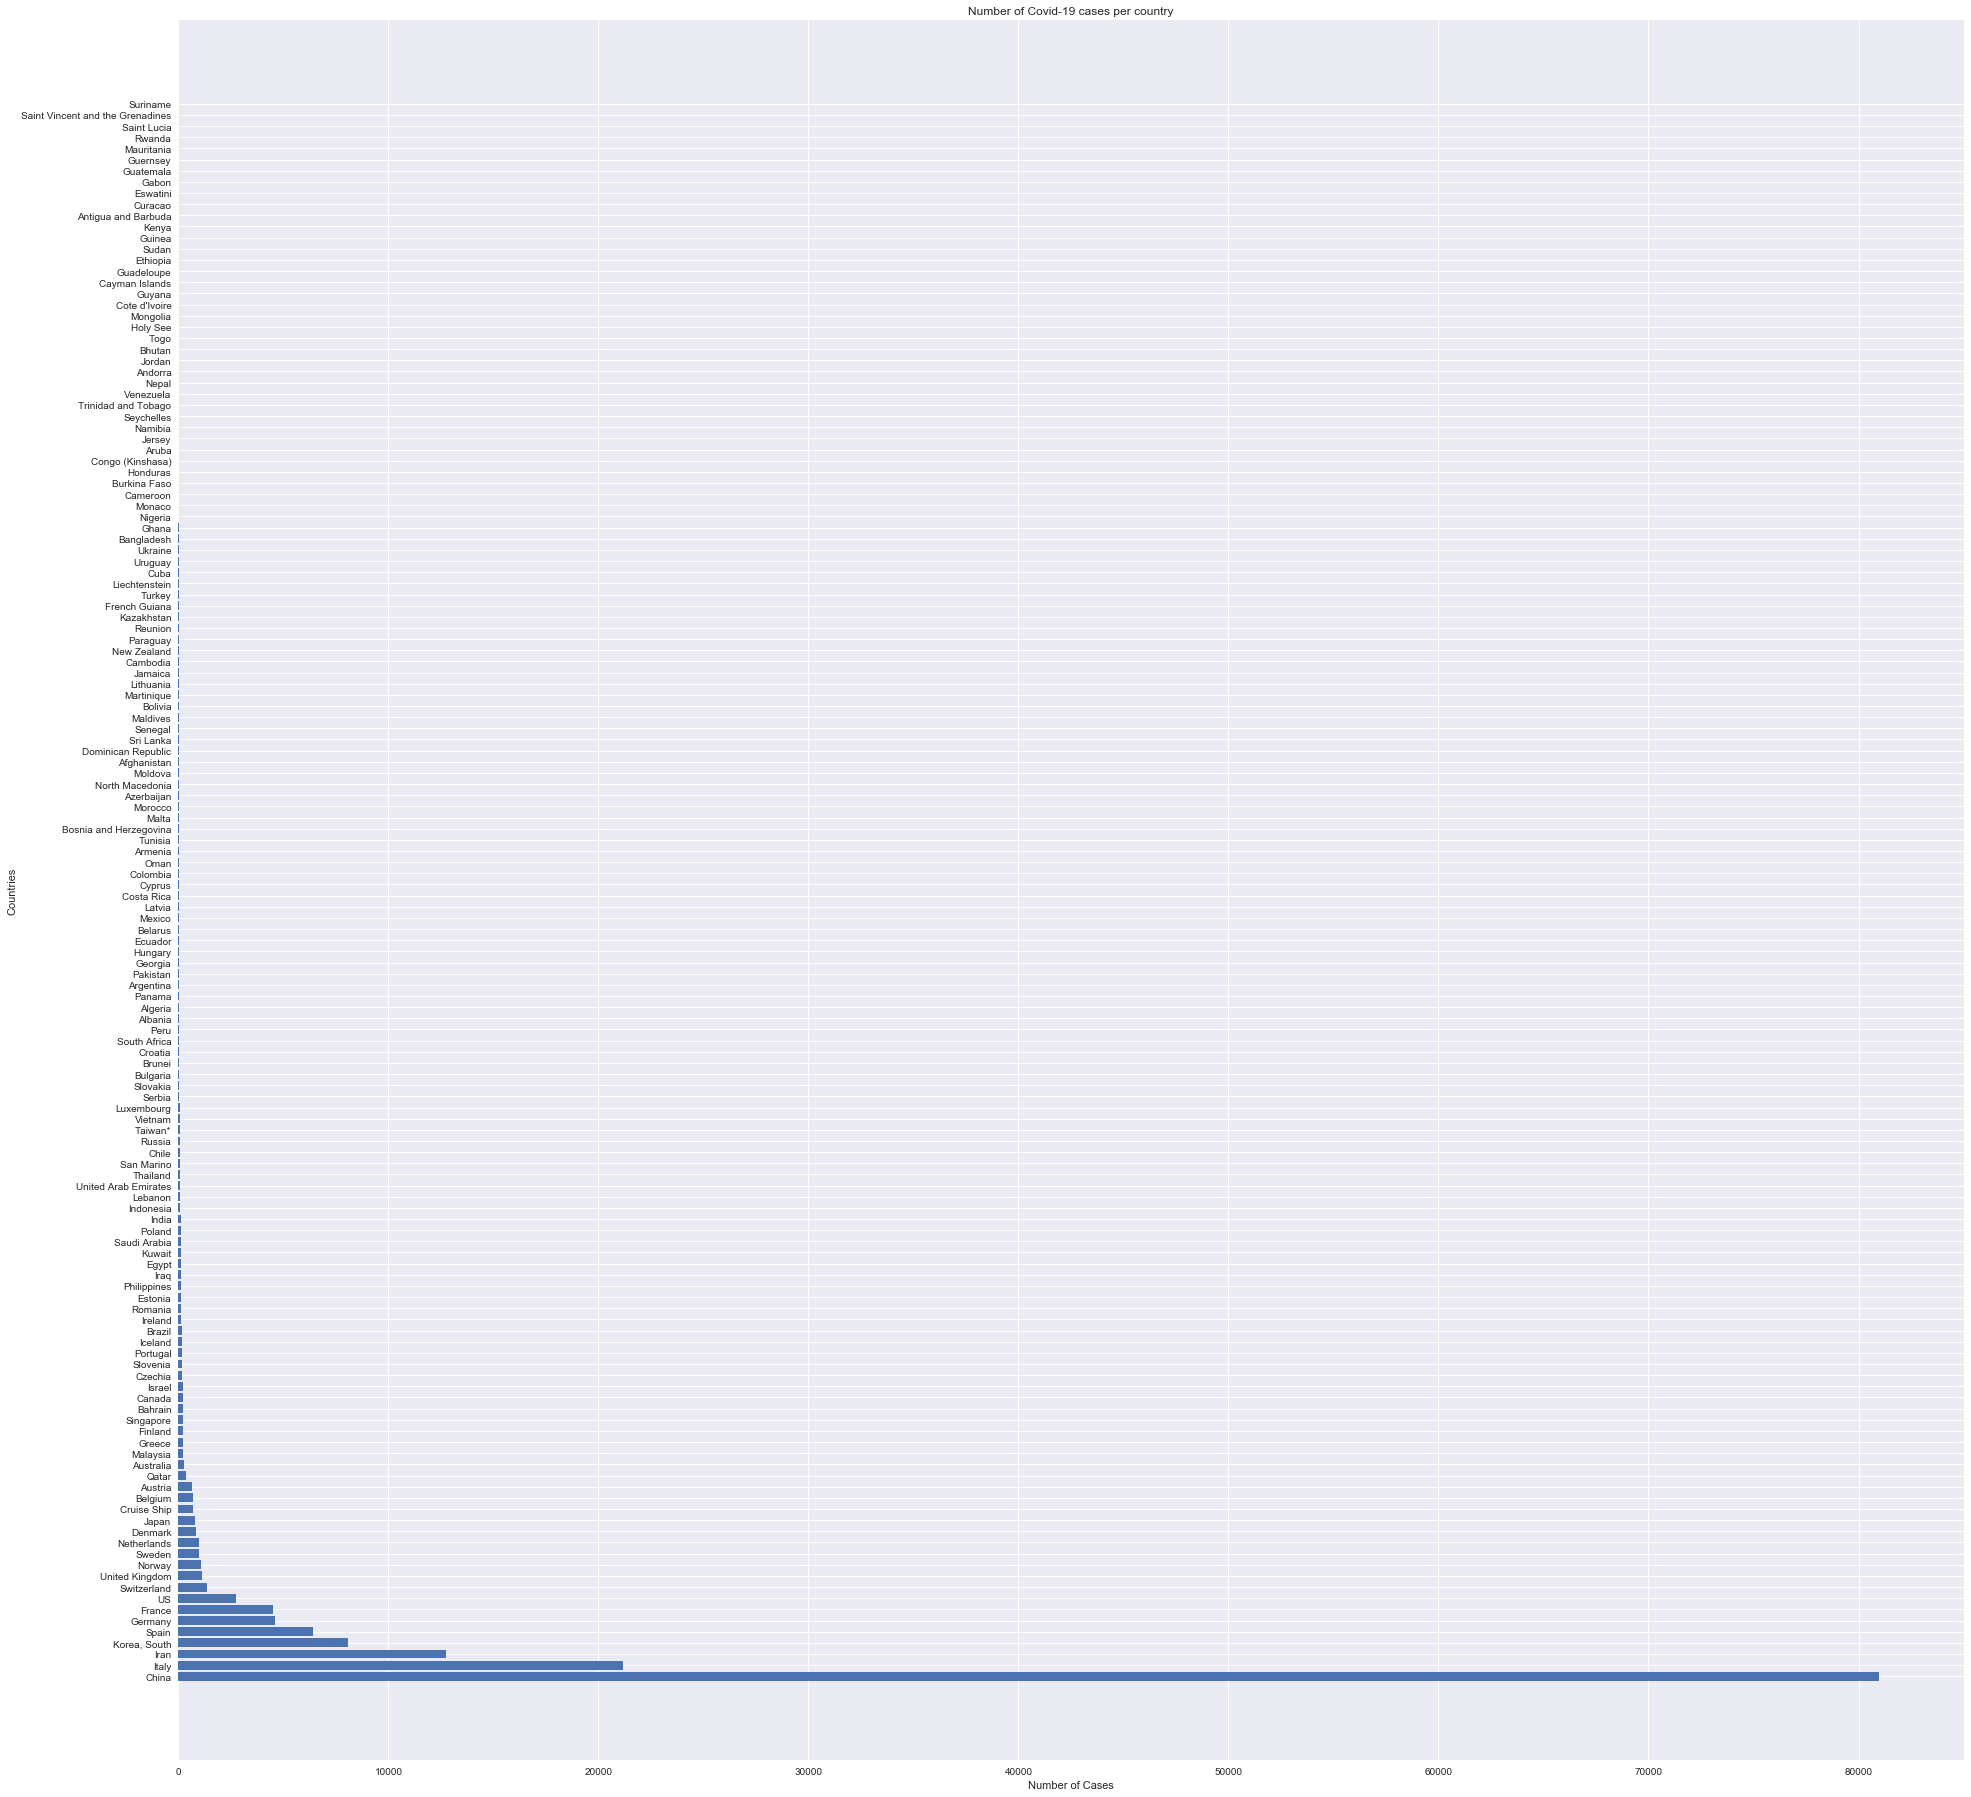

In [116]:
plt.figure(figsize=(32, 32))
plt.barh(countries, country_total_cases)
plt.title('Number of Covid-19 cases per country')
plt.xlabel('Number of Cases')
plt.ylabel('Countries')
plt.show()

In [118]:
kernel = ['poly', 'sigmoid', 'rbf']
c = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel':kernel, 'C':c, 'gamma':gamma, 'epsilon':epsilon, 'shrinking':shrinking}

X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_22_jan, total_cases, test_size=0.15, shuffle=False)

svm = SVR()
svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
svm_search.fit(X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   14.7s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'kernel': ['poly', 'sigmoid', 'rbf'],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [120]:
svm_search.best_params_

{'shrinking': True, 'kernel': 'poly', 'gamma': 0.01, 'epsilon': 1, 'C': 10}

In [124]:
svm_cases = svm_search.best_estimator_
svm_predict = svm_cases.predict(future_prediction)
svm_cases, svm_predict

(SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=1, gamma=0.01,
     kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
 array([ 30388.34430898,  30389.32176407,  30396.16394972,  30414.73559647,
         30450.90143487,  30510.52619549,  30599.47460886,  30723.61140555,
         30888.80131611,  31100.90907109,  31365.79940103,  31689.3370365 ,
         32077.38670805,  32535.81314622,  33070.48108157,  33687.25524466,
         34392.00036603,  35190.58117623,  36088.86240583,  37092.70878537,
         38207.9850454 ,  39440.55591648,  40796.28612915,  42281.04041398,
         43900.68350151,  45661.0801223 ,  47568.09500689,  49627.59288584,
         51845.43848971,  54227.49654904,  56779.63179439,  59507.70895631,
         62417.59276535,  65515.14795206,  68806.239247  ,  72296.73138072,
         75992.48908377,  79899.3770867 ,  84023.26012007,  88370.00291443,
         92945.47020032,  97755.52670831, 102806.03716895, 108102.86631278,
        113651.87

Mean Absolute Error 17238.106720993248
Mean Squared Error 311347361.9671531


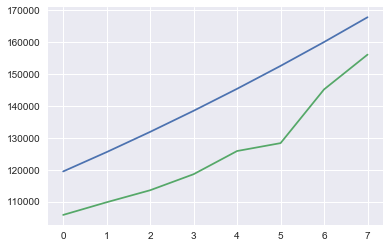

In [125]:
svm_test_predict = svm_cases.predict(X_test_confirmed)
plt.plot(svm_test_predict)
plt.plot(y_test_confirmed)

print('Mean Absolute Error', mean_absolute_error(svm_test_predict, y_test_confirmed))
print('Mean Squared Error', mean_squared_error(svm_test_predict, y_test_confirmed))

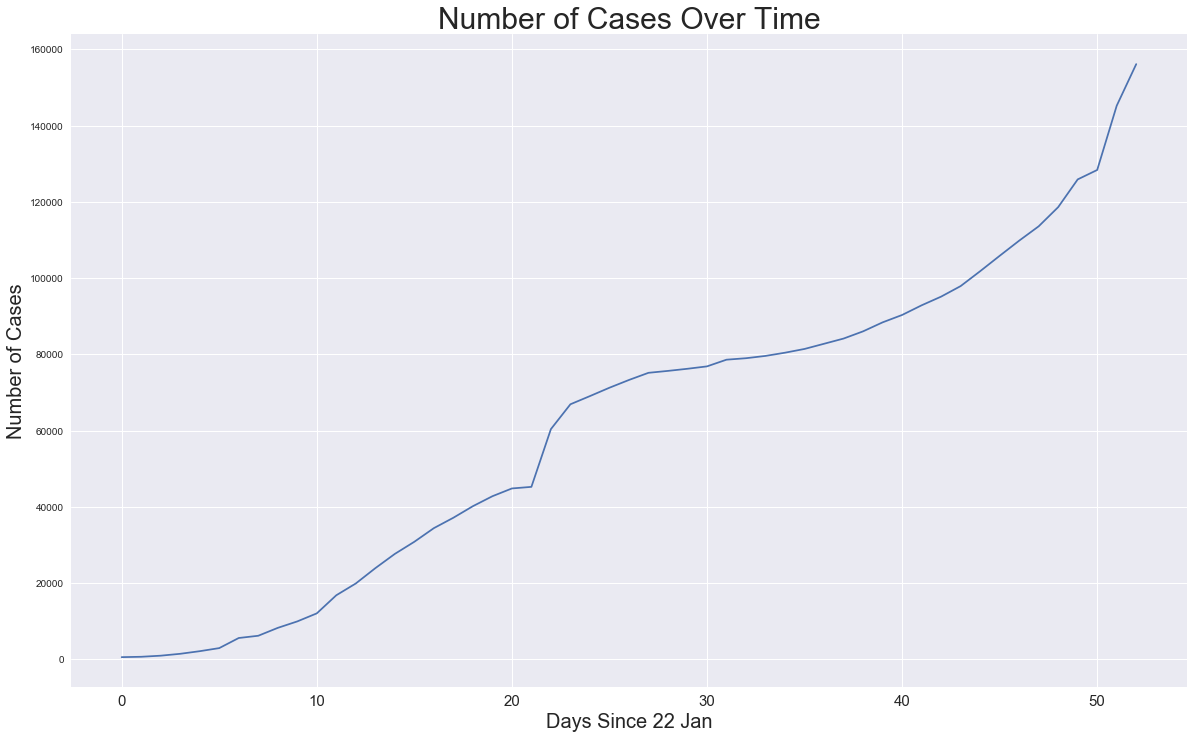

In [131]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_days, total_cases)
plt.title('Number of Cases Over Time', size=30)
plt.xlabel('Days Since 22 Jan', size=20)
plt.ylabel('Number of Cases', size=20)
plt.xticks(size=15)
plt.show()

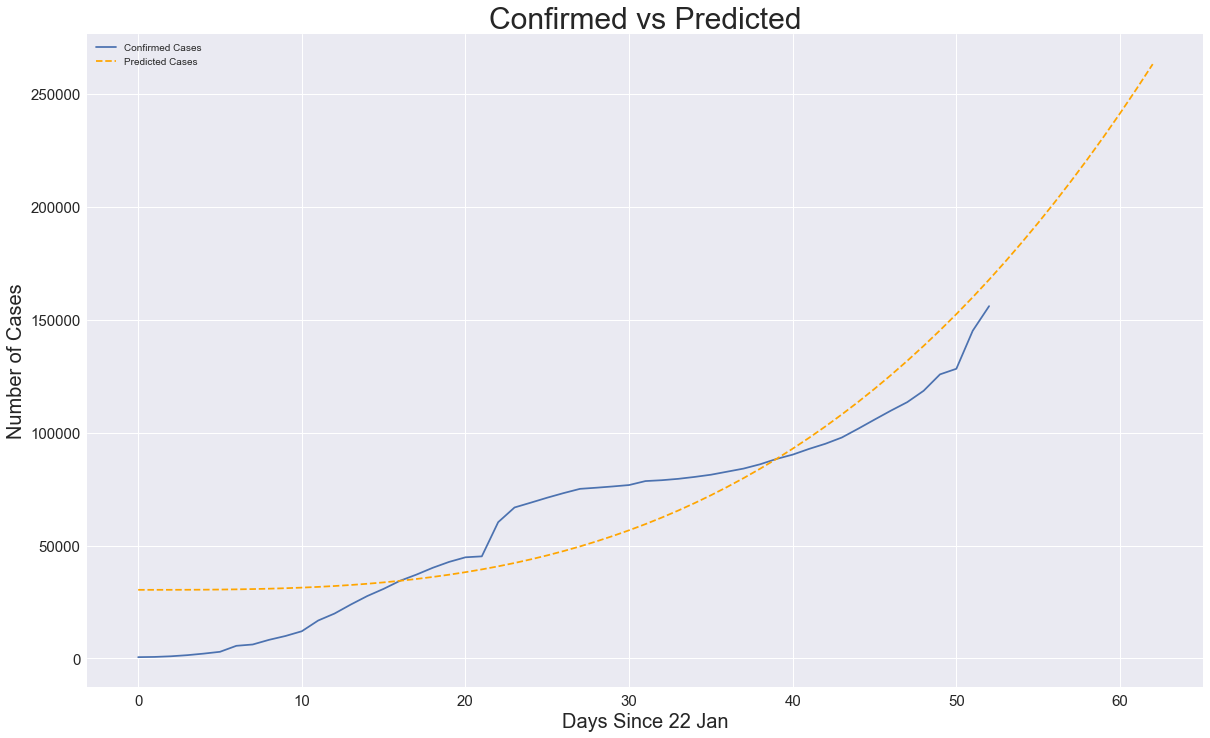

In [134]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_days, total_cases)
plt.plot(future_prediction, svm_predict, linestyle='dashed', color='orange')
plt.title('Confirmed vs Predicted', size=30)
plt.xlabel('Days Since 22 Jan', size=20)
plt.ylabel('Number of Cases', size=20)
plt.legend(['Confirmed Cases', 'Predicted Cases'])
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [137]:
print('Future Predictions (Next 10 Days)')
set(zip(future_prediction_dates[-10:],svm_predict[-10:]))

Future Predictions (Next 10 Days)


{('15/03/2020', 175908.92604843795),
 ('16/03/2020', 184302.3329238902),
 ('17/03/2020', 193012.43524916755),
 ('18/03/2020', 202045.0977548219),
 ('19/03/2020', 211406.18517140602),
 ('20/03/2020', 221101.56222947178),
 ('21/03/2020', 231137.09365957195),
 ('22/03/2020', 241518.64419225854),
 ('23/03/2020', 252252.0785580839),
 ('24/03/2020', 263343.2614876004)}

In [140]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression(normalize=True, fit_intercept=True)
linear_model.fit(X_train_confirmed, y_train_confirmed)
test_linear_predict = linear_model.predict(X_test_confirmed)
linear_predict = linear_model.predict(future_prediction)

print('Mean Absolute Error', mean_absolute_error(test_linear_predict, y_test_confirmed))
print('Mean Squared Error', mean_squared_error(test_linear_predict, y_test_confirmed))

Mean Absolute Error 8753.452020202018
Mean Squared Error 169179593.56311837


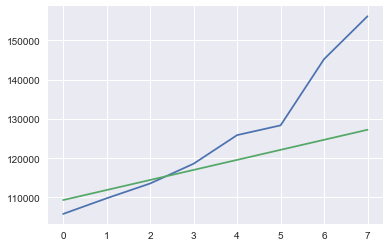

In [141]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_predict)

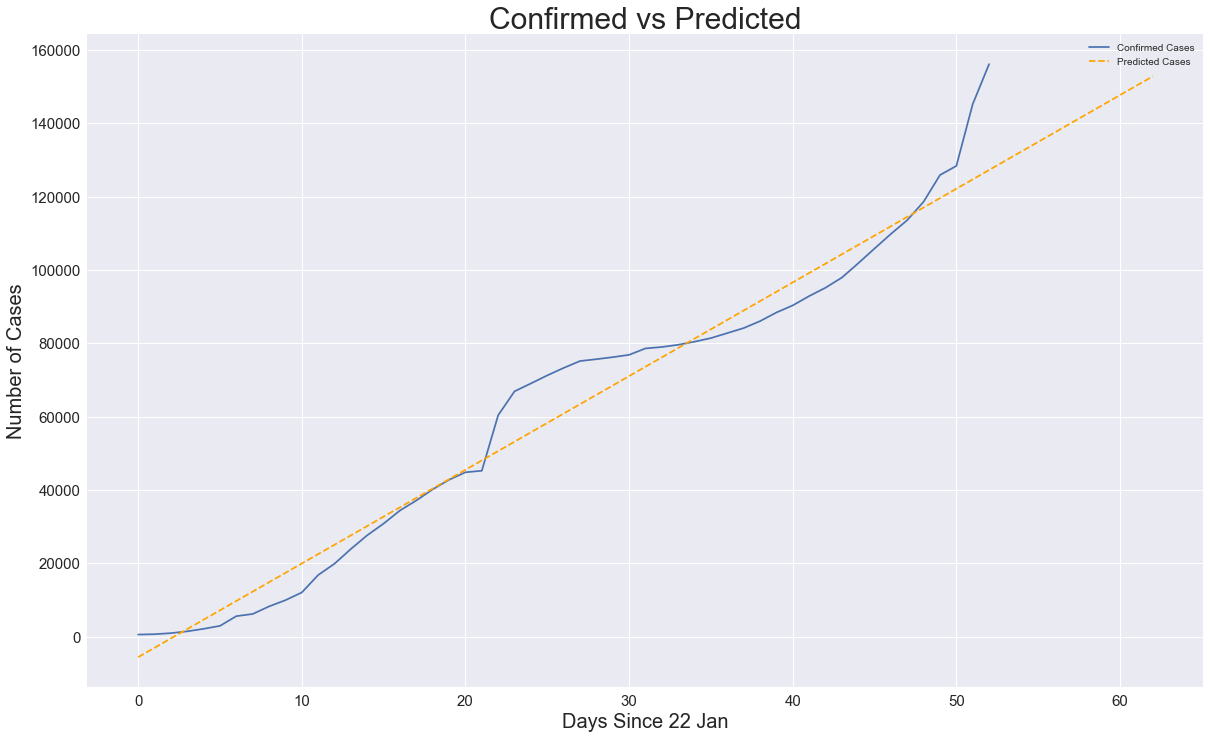

In [142]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_days, total_cases)
plt.plot(future_prediction, linear_predict, linestyle='dashed', color='orange')
plt.title('Confirmed vs Predicted', size=30)
plt.xlabel('Days Since 22 Jan', size=20)
plt.ylabel('Number of Cases', size=20)
plt.legend(['Confirmed Cases', 'Predicted Cases'])
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [144]:
print('Future Predictions (Next 10 Days)')
set(zip(future_prediction_dates[-10:],linear_predict[-10:]))

Future Predictions (Next 10 Days)


{('15/03/2020', 129781.78282828284),
 ('16/03/2020', 132336.25252525252),
 ('17/03/2020', 134890.72222222225),
 ('18/03/2020', 137445.19191919197),
 ('19/03/2020', 139999.66161616164),
 ('20/03/2020', 142554.13131313137),
 ('21/03/2020', 145108.60101010103),
 ('22/03/2020', 147663.07070707076),
 ('23/03/2020', 150217.54040404042),
 ('24/03/2020', 152772.01010101015)}

In [ ]:
# TODO: Plot more graphs from available data